In [1]:
import torch
import torch.nn as nn

In [2]:
# char_ids: [batch_size, max_seq_len, max_word_len]
char_ids = torch.randint(10, (1, 2, 3), dtype=torch.long)
batch_size, max_seq_len, max_word_len = char_ids.shape

In [3]:
print(char_ids)

tensor([[[5, 5, 2],
         [7, 3, 1]]])


In [4]:
char_dim = 4
char_embed = nn.Embedding(10, char_dim)
char_embedded = char_embed(char_ids)
print(char_embedded.shape) # [batch_size, max_seq_len, max_word_len, char_embedding_dim]
print(char_embedded)

torch.Size([1, 2, 3, 4])
tensor([[[[-0.4729, -1.7419, -0.8149,  0.8974],
          [-0.4729, -1.7419, -0.8149,  0.8974],
          [ 1.2032, -2.4092, -1.0361, -1.4598]],

         [[-0.3510, -1.3240, -0.1029,  0.1246],
          [ 0.3531,  1.4189, -1.1716, -0.1424],
          [-0.0359, -1.3063,  0.4996, -0.8041]]]], grad_fn=<EmbeddingBackward>)


In [5]:
char_embedded = char_embedded.view(-1, max_word_len, char_dim)
char_embedded = char_embedded.permute(0, 2, 1)
print(char_embedded.shape) # [batch_size*max_seq_len, char_embedding_dim, max_word_len]
print(char_embedded)

torch.Size([2, 4, 3])
tensor([[[-0.4729, -0.4729,  1.2032],
         [-1.7419, -1.7419, -2.4092],
         [-0.8149, -0.8149, -1.0361],
         [ 0.8974,  0.8974, -1.4598]],

        [[-0.3510,  0.3531, -0.0359],
         [-1.3240,  1.4189, -1.3063],
         [-0.1029, -1.1716,  0.4996],
         [ 0.1246, -0.1424, -0.8041]]], grad_fn=<PermuteBackward>)


In [6]:
# filter
conv1 = nn.Conv1d(char_dim, 3, kernel_size=3)

In [7]:
conv_out = conv1(char_embedded)
print(conv_out.shape) # [batch_size*max_seq_len, out_channels, max_word_len + 1 - kernel_size]
print(conv_out)

torch.Size([2, 3, 1])
tensor([[[-1.0170],
         [-0.5876],
         [-0.6721]],

        [[ 0.2706],
         [-0.0609],
         [ 0.8565]]], grad_fn=<SqueezeBackward1>)


In [8]:
import torch.nn.functional as F
output = F.max_pool2d(conv_out, kernel_size=(1, conv_out.shape[-1])).squeeze(-1)

In [9]:
print(output.shape) # [batch_size*max_seq_len, out_channels]
print(output)

torch.Size([2, 3])
tensor([[-1.0170, -0.5876, -0.6721],
        [ 0.2706, -0.0609,  0.8565]], grad_fn=<SqueezeBackward1>)


In [10]:
output.requires_grad

True

In [11]:
class HighwayMLP(nn.Module):
    """Implement highway network."""
    
    def __init__(self,
                 input_size,
                 activation=nn.functional.relu,
                 gate_activation=torch.sigmoid):
        
        super(HighwayMLP, self).__init__()
        
        self.act, self.gate_act = activation, gate_activation
        
        self.mlp = nn.Linear(input_size, input_size)
        self.transform = nn.Linear(input_size, input_size)

    def forward(self, x):
        """
        Args:
            x: [*, input_size]
        """
        mlp_out = self.act(self.mlp(x))
        gate_out = self.gate_act(self.transform(x))
        
        return gate_out * mlp_out + (1 - gate_out) * x

In [12]:
class CharCNN(nn.Module):
    """Character-level embedding with convolutional neural networks.
    """
    def __init__(self, 
                 char_size,
                 char_dim,
                 filter_num=10,
                 max_filter_size=7,
                 output_size=50,
                 padding_idx=0,
                 dropout=0.2):
        """Constructs CharCNN model.
        
        Args:
            char_size: total characters in the vocabulary.
            char_dim: character embedding size.
            filter_num: number of filters (each size).
            dropout: dropout rate.
        """
        super(CharCNN, self).__init__()
        
        self.char_dim = char_dim
        self.filter_num = filter_num
        self.max_filter_size = max_filter_size
        
        self.embed = nn.Embedding(char_size, 
                                  char_dim, 
                                  padding_idx=padding_idx)
        
        self.filters = nn.ModuleList()
        for size in range(1, max_filter_size + 1):
            self.filters.append(nn.Conv1d(char_dim, 
                                          filter_num, 
                                          kernel_size=size))
        
        self.highway = HighwayMLP(max_filter_size * filter_num)
        self.proj = nn.Linear(max_filter_size * filter_num, output_size)

        
    def forward(self, char_ids, word_lens):
        """
        Args:
            char_ids: [batch_size, max_seq_len, max_word_len]
            word_lens: [batch_size, max_seq_len]

        Return:
            c_emb: [batch_size, max_seq_len, char_hidden_dim]
        """
        batch_size, max_seq_len, max_word_len = char_ids.shape
        
        # embedding
        char_embedded = self.embed(char_ids)
        char_embedded = char_embedded.view(-1, max_word_len, self.char_dim)
        char_embedded = char_embedded.permute(0, 2, 1) # [batch_size*max_seq_len, char_dim, max_word_len]
        
        # convolution layer & max pooling
        outputs = []
        for i, conv in enumerate(self.filters):
            if i + 1 <= max_word_len:
                conv_out = conv(char_embedded)
                out = F.max_pool2d(conv_out, kernel_size=(1, conv_out.shape[-1]))
                out = out.squeeze(-1) # [batch_size*max_seq_len, filter_num]
                outputs.append(out)
        
        outputs = torch.cat(outputs, -1)
        outputs = self._pad_outputs(outputs)
        assert outputs.shape == (batch_size * max_seq_len, self.max_filter_size * self.filter_num)
        
        # highway network
        highway_out = self.highway(outputs)
        
        # proj
        final_out = torch.relu(self.proj(highway_out))
        final_out = final_out.view(batch_size, max_seq_len, -1)
        
        return final_out
    
    
    def _pad_outputs(self, x):
        """In case the max word length is less than the max filter width, 
           use this function to pad the output.
           
        Args:
            x: tensor, [batch_size * max_seq_len, N * filter_num] (N <= max_filter_size)

        return:
            out: tensor, [batch_size * max_seq_len, max_filter_size * filter_num]
        """
        bm, input_size = x.shape
        dim_to_pad = self.filter_num * self.max_filter_size - input_size
        assert dim_to_pad >= 0
        
        if dim_to_pad == 0:
            return x
        else: 
            padder = torch.zeros((bm, dim_to_pad), dtype=x.dtype, device=x.device)
            out = torch.cat((x, padder), -1)
            return out

In [13]:
charCNN = CharCNN(char_size=100,
                  char_dim=20,
                  filter_num=10,
                  max_filter_size=7,
                  output_size=50)

In [14]:
char_ids = torch.randint(100, [32, 20, 10], dtype=torch.int64)
out = charCNN(char_ids, None)

In [15]:
out.shape

torch.Size([32, 20, 50])

### Visualizaton

In [18]:
import os
from torchviz import make_dot
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

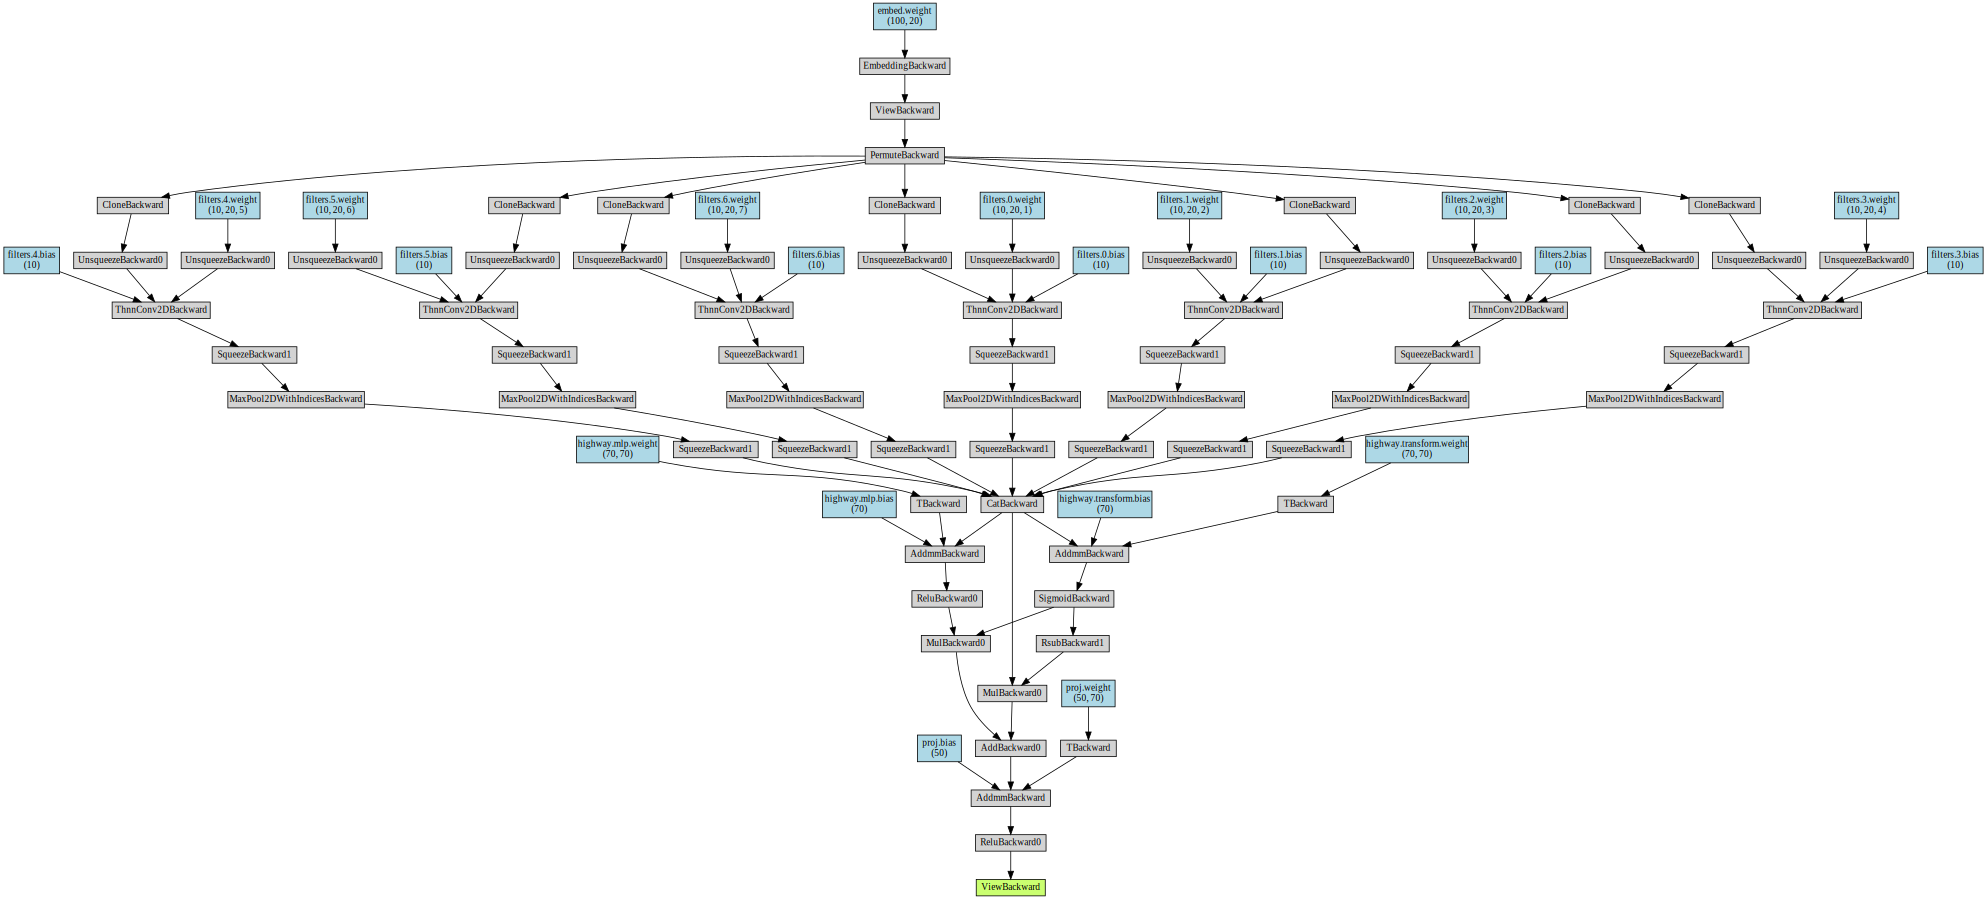

In [19]:
make_dot(charCNN(char_ids, None), params=dict(charCNN.named_parameters()))